<a href="https://colab.research.google.com/github/snehitvaddi/NovelCorona-Pneumonia-Prediction_V2/blob/master/Skin_Diseade_3_models_CNN%26TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** and also custom CNN to train the model to compare accurate results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Note:** Before you run, Import the dataset into your google drive and then try updating the paths specific to yout drive.

## 📚 Dataset: https://drive.google.com/drive/folders/1YCDqMawf0Iua64rV66z24rgAYDdTMkNc?usp=sharing

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcinoma/ISIC_0026645.jpg
/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcinoma/ISIC_0026203.jpg
/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcinoma/ISIC_0026138.jpg
/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcinoma/ISIC_0025811.jpg
/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcinoma/ISIC_0025471.jpg
/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)/Train/squamous cell carcino

---

# Data Preperation

In [ ]:
labels = ["actinic keratosis", 
"dermatofibroma", 
"melanoma", 
"seborrheic keratosis", 
"squamous cell carcinoma"
]

In [ ]:
!pwd

/content


We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
X_train = []
y_train = []
image_size = 150
dir = '/content/drive/MyDrive/Projects-for-Sale/Proj - 2 Skin Disease Identification Using Image Analysis/dataset (skin diseases)'
for i in labels:
    folderPath = os.path.join(dir,'Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(dir,'Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


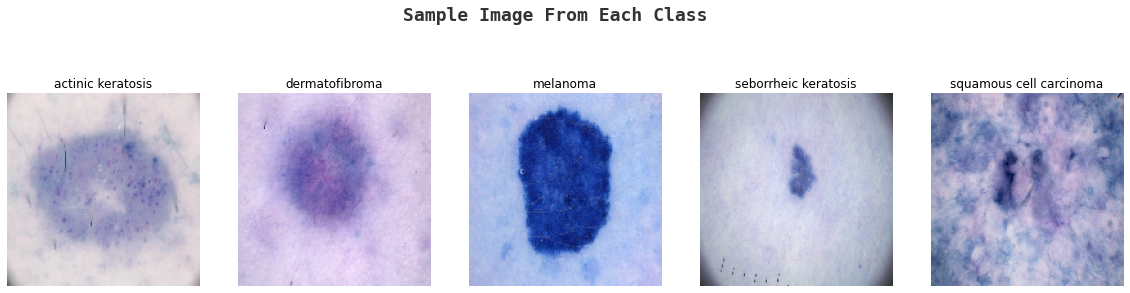

In [ ]:
k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Sample Image From Each Class ',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(631, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

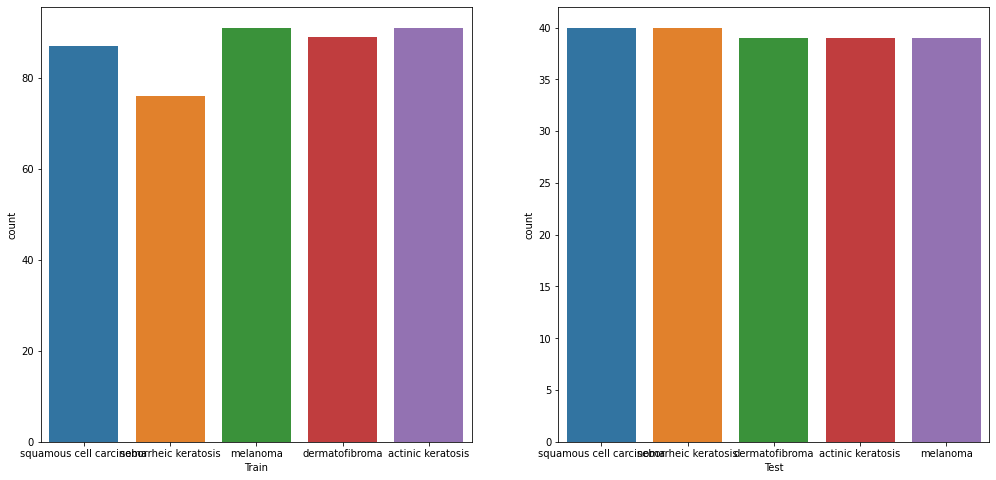

In [ ]:
train_labels = []
test_labels = []

img_size= 300

for i in os.listdir(dir+'/Train/'):
    for j in os.listdir(dir+"/Train/"+i):
       train_labels.append(i)
        
for i in os.listdir(dir+'/Test/'):
    for j in os.listdir(dir+"/Test/"+i):
        test_labels.append(i)

plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

---

# Custom CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model

# Start training freshly
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("skin-snehit.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
31/32 [============================>.] - ETA: 0s - loss: 2.9693 - accuracy: 0.2843
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to skin-snehit.h5
32/32 [==============================] - 2s 31ms/step - loss: 2.9215 - accuracy: 0.2941 - val_loss: 1.4091 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/30
30/32 [===========================>..] - ETA: 0s - loss: 1.0665 - accuracy: 0.5542
Epoch 2: val_accuracy did not improve from 0.33333
32/32 [==============================] - 1s 19ms/step - loss: 1.0622 - accuracy: 0.5549 - val_loss: 1.5046 - val_accuracy: 0.3158 - lr: 0.0010
Epoch 3/30
29/32 [==========================>...] - ETA: 0s - loss: 0.8477 - accuracy: 0.6703
Epoch 3: val_accuracy improved from 0.33333 to 0.50877, saving model to skin-snehit.h5
32/32 [==============================] - 1s 22ms/step - loss: 0.8528 - accuracy: 0.6686 - val_loss: 1.2552 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 4/30
30/32 [===========================>..] - ETA: 0s - loss:

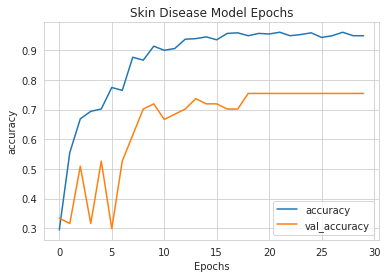

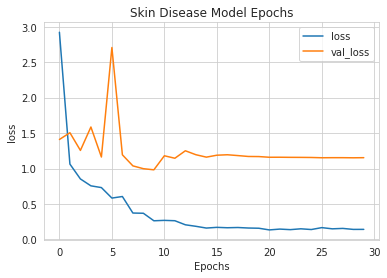

In [ ]:
#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Skin Disease Model Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.85      0.92      0.88        12
           2       1.00      0.69      0.82        13
           3       0.72      1.00      0.84        13
           4       0.92      0.73      0.81        15

    accuracy                           0.86        64
   macro avg       0.88      0.87      0.86        64
weighted avg       0.88      0.86      0.86        64



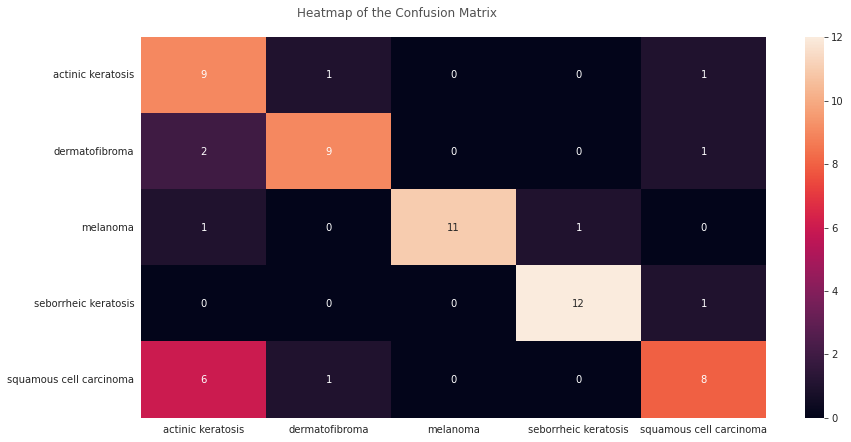

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

# Transfer Learning _ EfficientNet B0

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(5,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

We finally compile our model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("skin-snehit.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 1.0318 - accuracy: 0.6216
Epoch 1: val_accuracy improved from -inf to 0.63158, saving model to skin-snehit.h5
32/32 [==============================] - 16s 197ms/step - loss: 1.0318 - accuracy: 0.6216 - val_loss: 1.0255 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8667
Epoch 2: val_accuracy did not improve from 0.63158
32/32 [==============================] - 3s 84ms/step - loss: 0.4387 - accuracy: 0.8667 - val_loss: 1.8315 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9157
Epoch 3: val_accuracy did not improve from 0.63158

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
32/32 [==============================] - 3s 85ms/step - loss: 0.2683 - accuracy: 0.9157 - val_loss: 1.4160 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 4/30
32/32 [======

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.85      0.92      0.88        12
           2       1.00      0.69      0.82        13
           3       0.72      1.00      0.84        13
           4       0.92      0.73      0.81        15

    accuracy                           0.86        64
   macro avg       0.88      0.87      0.86        64
weighted avg       0.88      0.86      0.86        64



In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

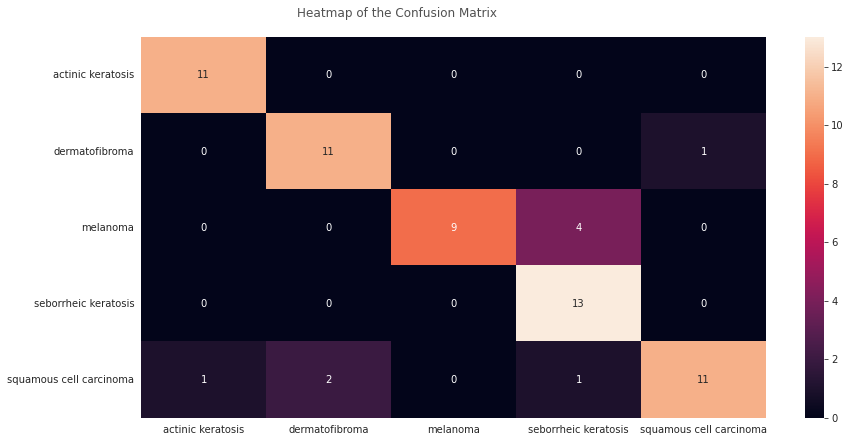

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

### Table for Training Dataset

In [ ]:
pred = model.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

matrix = confusion_matrix(y_train_new,pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.98319328, 0.96551724, 0.99145299, 1.        , 1.        ])

In [ ]:
import math
print(91, 89, 91, 76, 87)
print(math.ceil(0.98319328*91), math.ceil(0.96551724*89), math.ceil(0.99145299*91), math.ceil(1.0*76), math.ceil(1.0*87))
print(math.ceil(0.98319328*100), math.ceil(0.96551724*100), math.ceil(0.99145299*100), math.ceil(1.0*100), math.ceil(1.0*100))

91 89 91 76 87
90 86 91 76 87
99 97 100 100 100


### Table for Testing Dataset

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

matrix = confusion_matrix(y_test_new,pred)
matrix.diagonal()/matrix.sum(axis=1)

array([1.        , 0.91666667, 0.69230769, 1.        , 0.73333333])

In [ ]:
import math
print(39, 39, 39, 40, 40)
print(math.ceil(1.0*39), math.ceil(0.91666667*39), math.ceil(0.69230769*39), math.ceil(1.0*40), math.ceil(0.73333333*40))
print(math.ceil(1.0*100), math.ceil(0.91666667*100), math.ceil(0.69230769*100), math.ceil(1.0*100), math.ceil(0.73333333*100))

39 39 39 40 40
39 36 27 40 30
100 92 70 100 74


---

# Transfer Learning _ Inception V3

In [ ]:
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3

from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from keras.layers.advanced_activations import PReLU, LeakyReLU

In [ ]:
from keras.applications.inception_v3 import InceptionV3

tf.keras.backend.clear_session()

# We use model inceptionV3
pre_train_model = InceptionV3(
      include_top = False,
      weights = "imagenet",
      input_shape = (image_size,image_size, 3)      
)

In [ ]:
# pre_train_model.summary()

In [ ]:
# just use a part of model because our task is simple so if use whole model will be overfitting

for layer in pre_train_model.layers:
    layer.trainable = False
last_layer = pre_train_model.get_layer('mixed9')  # cut begin to layer block8_9_mixed
last_output = pre_train_model.output

In [ ]:
# Add some custom layer to do our task, output will be 1 node
# x = MaxPooling2D(pool_size=(2,2))(last_output)
x = Flatten()(last_output)
# x = Dense(2048, activation='relu')(x)
# x = Dense(1024, activation='relu')(x)
# x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

In [ ]:
# Define optimizer, learning rate and loss function
model = Model(pre_train_model.input, output)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("Inception V3-model-28.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =28, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/28
32/32 [==============================] - 31s 829ms/step - loss: 19.6015 - acc: 0.2647 - val_loss: 4.3663 - val_acc: 0.2807 - lr: 1.0000e-04
Epoch 2/28
32/32 [==============================] - 28s 891ms/step - loss: 3.7563 - acc: 0.2863 - val_loss: 1.6358 - val_acc: 0.2456 - lr: 1.0000e-04
Epoch 3/28
32/32 [==============================] - 22s 678ms/step - loss: 1.6476 - acc: 0.3510 - val_loss: 1.4296 - val_acc: 0.4386 - lr: 1.0000e-04
Epoch 4/28
32/32 [==============================] - 21s 660ms/step - loss: 1.5281 - acc: 0.3353 - val_loss: 1.3839 - val_acc: 0.4386 - lr: 1.0000e-04
Epoch 5/28
32/32 [==============================] - 21s 662ms/step - loss: 1.4130 - acc: 0.3725 - val_loss: 1.3880 - val_acc: 0.4737 - lr: 1.0000e-04
Epoch 6/28
32/32 [==============================] - 21s 663ms/step - loss: 1.3761 - acc: 0.3431 - val_loss: 1.5617 - val_acc: 0.3509 - lr: 1.0000e-04
Epoch 7/28
32/32 [==============================] - 22s 703ms/step - loss: 1.3639 - acc: 0.3725 - v

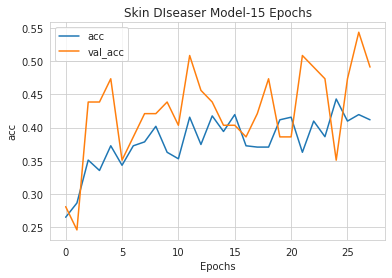

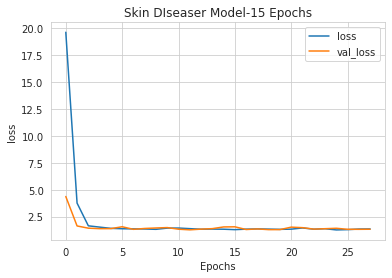

In [ ]:
#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Skin DIseaser Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'acc')
plot_graphs(history,'loss')

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

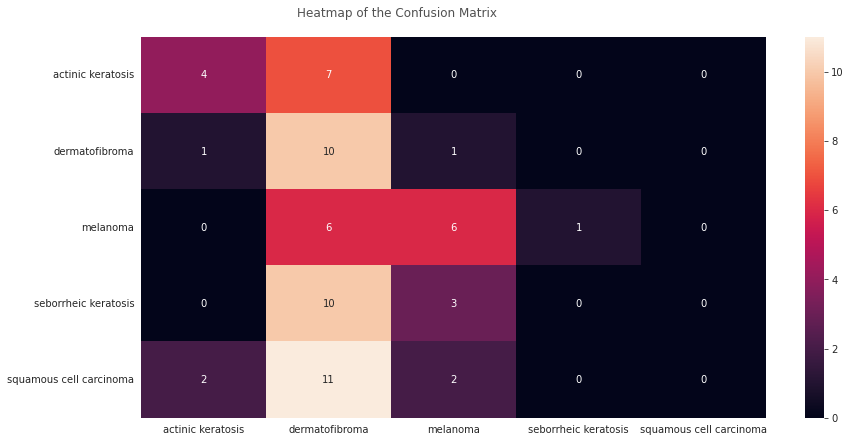

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:


def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')

uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()

button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

### Upload Weights to drive for later use.

In [ ]:
!mv '/content/EfficientNetD0-12.h5' '/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/'
!mv '/content/IEEE-model-28.h5' '/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/'

In [ ]:
# !pip install jovian
import jovian
jovian.commit(environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


---

# Vision Transformers

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
X_train = []
y_train = []
image_size = 150
dir = '/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/dataset'
for i in labels:
    folderPath = os.path.join(dir,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(dir,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 64/64 [00:00<00:00, 111.03it/s]


In [ ]:
num_classes = 4
input_shape = (150, 150, 3)
(x_train, x_test, y_train, y_test)  = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1215, 150, 150, 3) - y_train shape: (1215,)
x_test shape: (135, 150, 150, 3) - y_test shape: (135,)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

(-0.5, 149.5, 149.5, -0.5)

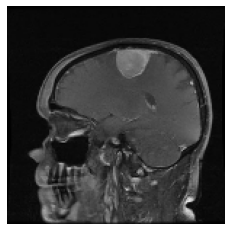

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 28
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


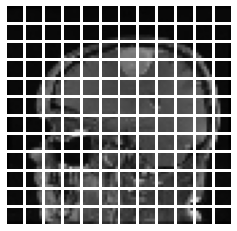

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
!pwd

/content


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/28


UnimplementedError: ignored